In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import f_oneway

In [3]:
# load data
data = np.load('../dataset/development.npy')
# load metadata
feature_map = pd.read_csv('../dataset/idx_to_feature_name.csv')
feature_names = dict(zip(feature_map['index'], feature_map['feature_name']))
development_df = pd.read_csv('../dataset/development.csv')

# A. How are the pre-computed audio features distributed?

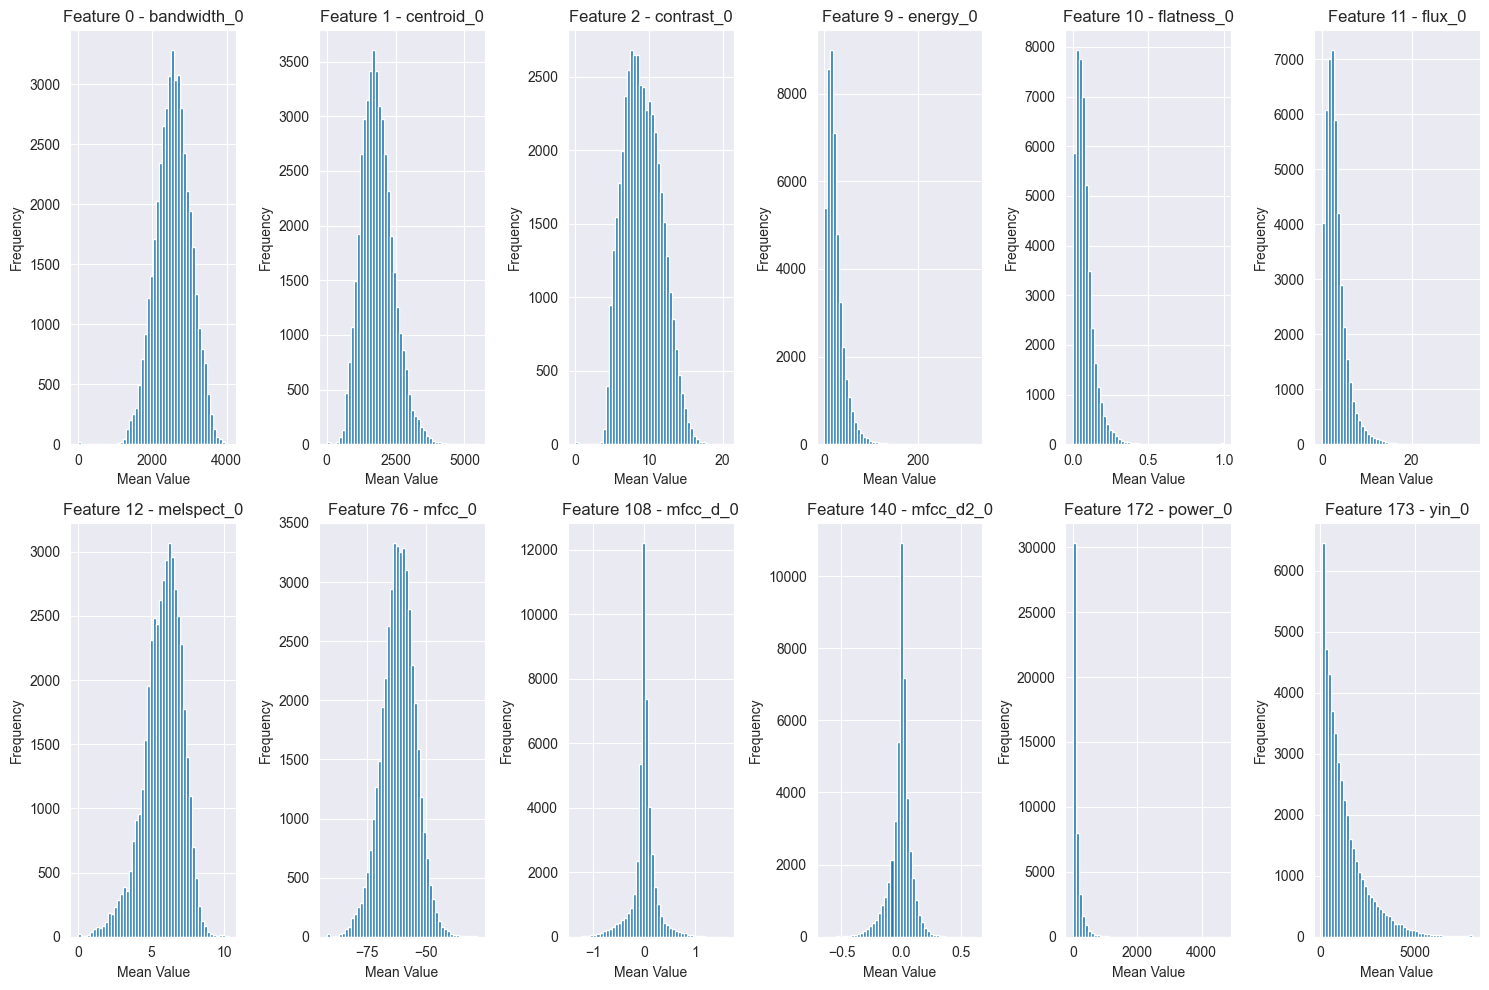

In [16]:
features_to_plot = [0, 1, 2, 9, 10, 11, 12, 76, 108, 140, 172, 173, 174]
features_to_plot = [0, 1, 2, 9, 10, 11, 12, 76, 108, 140, 172, 173]
#log_transform_features = [9, 10, 11, 172, 173, 174]

# grid size for subplots
num_features = len(features_to_plot)
grid_size = int(np.ceil(np.sqrt(num_features)))
x_grid_size = 6
y_grid_size = 2

plt.figure(figsize=(15, 10))

for i, feature_index in enumerate(features_to_plot, start=1):
    selected_feature = data[:, feature_index, :]
    
    # log transformation
    #if feature_index in log_transform_features:
    #    selected_feature = np.log(selected_feature + 0.01)
    
    # Compute mean
    mean_feature = np.mean(selected_feature, axis=1)
    
    # create subplots
    plt.subplot(y_grid_size, x_grid_size, i)
    plt.hist(mean_feature, bins=50)
    plt.title(f'Feature {feature_index} - {feature_names.get(feature_index)}')
    plt.xlabel('Mean Value')
    plt.ylabel('Frequency')
# spacing between subplots
plt.tight_layout()
plt.savefig('fig/feature_dist.eps')
plt.show()

# B. Are there any pairs or subsets of features that seem highly correlated or redundant?

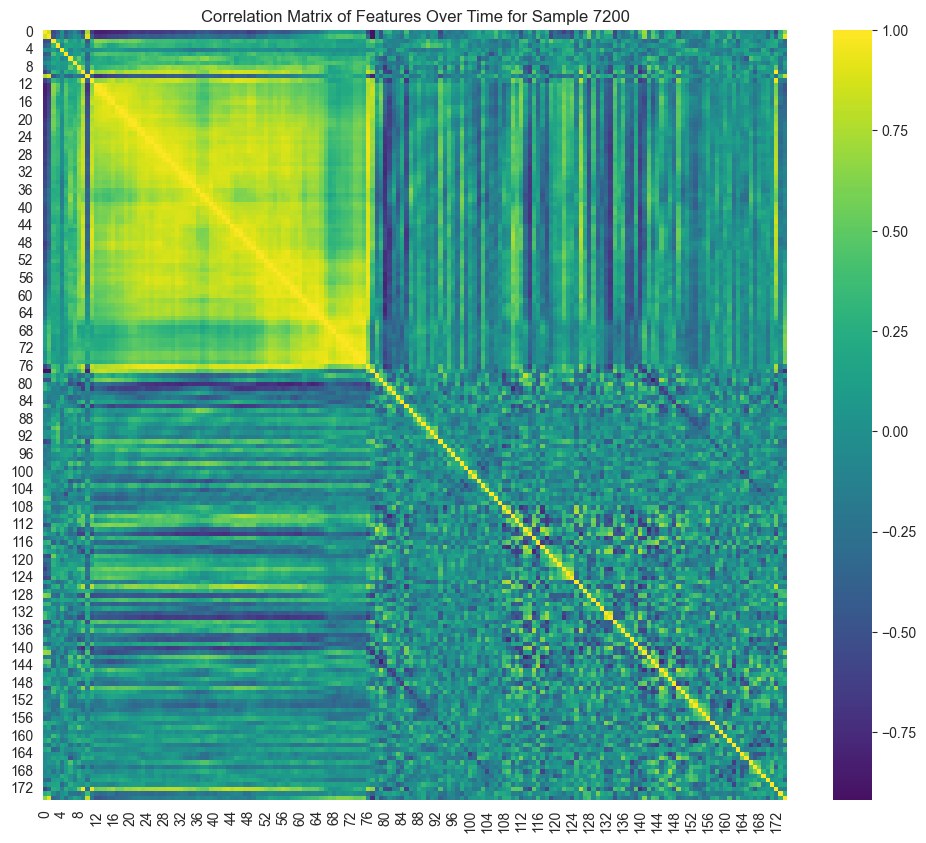

Pairs of features with correlation > 0.95: [('energy_0', 'flux_0'), ('energy_0', 'power_0'), ('flux_0', 'energy_0'), ('melspect_0', 'melspect_1'), ('melspect_1', 'melspect_0'), ('melspect_1', 'melspect_2'), ('melspect_2', 'melspect_1'), ('melspect_3', 'melspect_4'), ('melspect_4', 'melspect_3'), ('melspect_5', 'melspect_6'), ('melspect_6', 'melspect_5'), ('melspect_6', 'melspect_7'), ('melspect_7', 'melspect_6'), ('melspect_8', 'melspect_9'), ('melspect_9', 'melspect_8'), ('melspect_12', 'melspect_13'), ('melspect_13', 'melspect_12'), ('melspect_14', 'melspect_15'), ('melspect_15', 'melspect_14'), ('melspect_15', 'melspect_16'), ('melspect_16', 'melspect_15'), ('melspect_16', 'melspect_17'), ('melspect_17', 'melspect_16'), ('melspect_18', 'melspect_19'), ('melspect_19', 'melspect_18'), ('melspect_20', 'melspect_21'), ('melspect_21', 'melspect_20'), ('melspect_21', 'melspect_22'), ('melspect_22', 'melspect_21'), ('melspect_22', 'melspect_23'), ('melspect_23', 'melspect_22'), ('melspect_

In [5]:

sample = 7200
sample_data = data[sample, :, :]
# Transpose to get shape (time, features)
sample_data_reshaped = sample_data.T
# convert to dataframe
df_sample = pd.DataFrame(sample_data_reshaped)
# compute correlation matrix
correlation_matrix = df_sample.corr()
# plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="viridis", center=0)
plt.title(f"Correlation Matrix of Features Over Time for Sample {sample}")
plt.show()
# exclude diagonal
np.fill_diagonal(correlation_matrix.values, np.nan)
# get pairs with correlation > 0.95
high_correlation = np.where(correlation_matrix > 0.95)
high_correlation = [(feature_names.get(i), feature_names.get(j)) for i, j in zip(high_correlation[0], high_correlation[1])]
print(f"Pairs of features with correlation > 0.95: {high_correlation}")

# C. Are there differences in the feature distributions for different speakers?

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


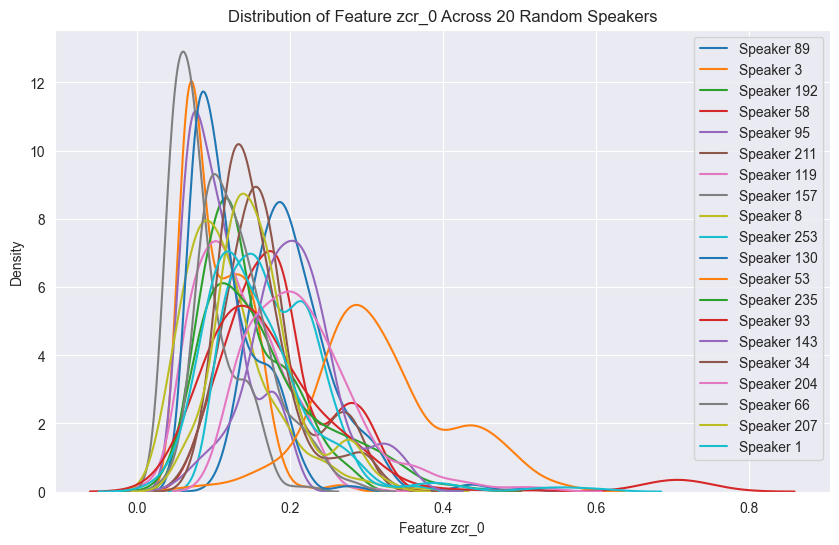

In [8]:
# randomly select 20 speakers
random_speakers = np.random.choice(development_df['speaker_id'].unique(), size=20, replace=False)
# only include selected speakers
filtered_df = development_df[development_df['speaker_id'].isin(random_speakers)]
speaker_features = {speaker_id: [] for speaker_id in random_speakers}
# aggregate features for each speaker
for index, row in filtered_df.iterrows():
    speaker_id = row['speaker_id']
    sample_index = row['id']
    # mean across time
    aggregated_features = np.mean(data[sample_index], axis=1)
    speaker_features[speaker_id].append(aggregated_features)
    
# convert to array
for speaker_id in random_speakers:
    speaker_features[speaker_id] = np.array(speaker_features[speaker_id])

# plot kernel density estimate (KDE)  
feature_index = 174
plt.figure(figsize=(10, 6))
for speaker_id in random_speakers:
    sns.kdeplot(speaker_features[speaker_id][:, feature_index], label=f"Speaker {speaker_id}")

plt.title(f'Distribution of Feature {feature_names.get(feature_index)} Across 20 Random Speakers')
plt.xlabel(f'Feature {feature_names.get(feature_index)}')
plt.ylabel('Density')
plt.legend()
plt.savefig('fig/speakers_zcr0.eps')
plt.show()

## Boxplot and Analysis of Variance

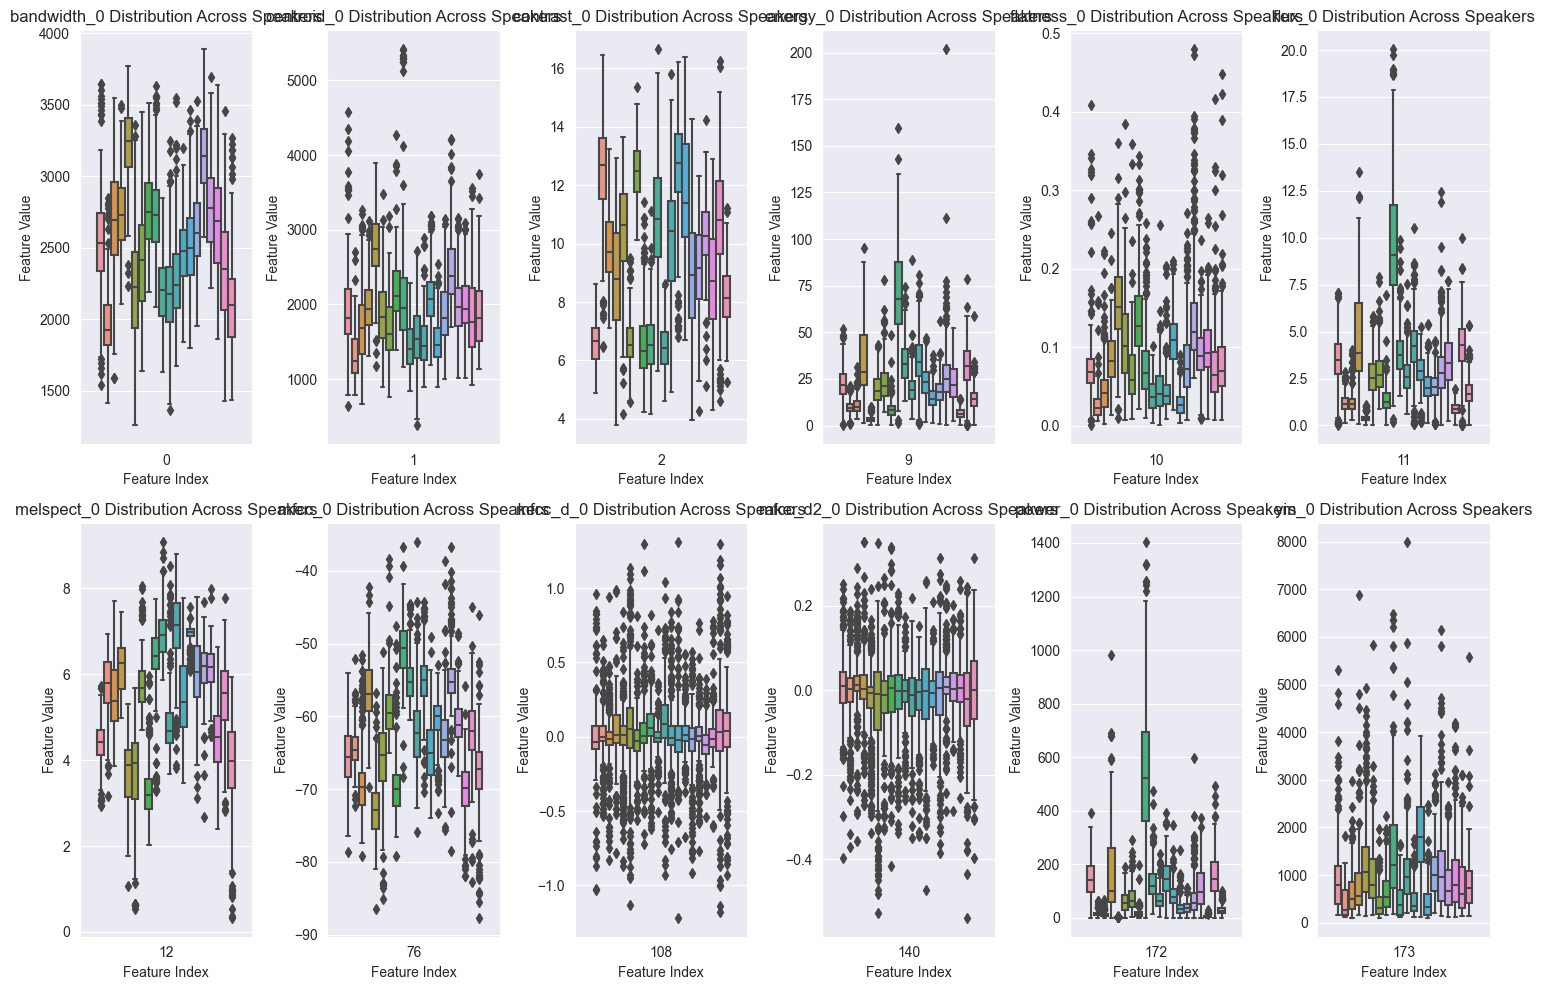

yin_0
ANOVA F-statistic: 82.2582623176265, P-value: 2.949516422797287e-279


In [15]:
data_for_plotting = []
for speaker_id, features in speaker_features.items():
    for feature_values in features:
        for feature_index, feature_value in enumerate(feature_values):
            data_for_plotting.append({
                'Speaker ID': speaker_id,
                'Feature Value': feature_value,
                'Feature Index': feature_index
            })

# Convert to dataframe
df_plot = pd.DataFrame(data_for_plotting)

features_to_plot = [0, 1, 2, 9, 10, 11, 12, 76, 108, 140, 172, 173, 174]
features_to_plot = [0, 1, 2, 9, 10, 11, 12, 76, 108, 140, 172, 173]
# subplot grid size
num_features = len(features_to_plot)
grid_size = int(np.ceil(np.sqrt(num_features)))
x_grid_size = 6
y_grid_size = 2

plt.figure(figsize=(15, 10))

for i, feature_index in enumerate(features_to_plot, start=1):
    ax = plt.subplot(y_grid_size, x_grid_size, i)
    sns.boxplot(x='Feature Index', y='Feature Value', hue='Speaker ID',
                data=df_plot[df_plot['Feature Index'] == feature_index])
    plt.title(f'{feature_names.get(feature_index)} Distribution Across Speakers')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    ax.get_legend().remove()


# spacing between subplots
plt.tight_layout()
plt.savefig('fig/speakers_dist.eps')
plt.show()

# analysis of Variance (ANOVA)
groups = []
for speaker_id, features in speaker_features.items():
    if speaker_id in random_speakers:
        group = features[:, feature_index]
        groups.append(group)

f_stat, p_value = f_oneway(*groups)
print(feature_names.get(feature_index))
print(f"ANOVA F-statistic: {f_stat}, P-value: {p_value}")
